In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

2022-08-16 13:20:56,067 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55561143.gadi-pbs/dask-worker-space/worker-5q1_5tmy', purging
2022-08-16 13:20:56,067 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55561143.gadi-pbs/dask-worker-space/worker-q4g0ht_3', purging
2022-08-16 13:20:56,068 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55561143.gadi-pbs/dask-worker-space/worker-dfm4vru9', purging
2022-08-16 13:20:56,068 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55561143.gadi-pbs/dask-worker-space/worker-4eb6tp2e', purging
2022-08-16 13:20:56,068 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/55561143.gadi-pbs/dask-worker-space/worker-v11cdmko', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45293,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:36685,Total threads: 4
Dashboard: /proxy/43809/status,Memory: 25.04 GiB
Nanny: tcp://127.0.0.1:32947,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2155-01-01'

lat_slice = slice(-90,-59)
lon_slice = slice(-280,80)
isobath_depth = 1000

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

In [17]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [6]:
start_time='2150-01-01'
end_time='2155-01-01'

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

#Import seaice
hi_con = cc.querying.getvar(control, 'hi_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_con = cc.querying.getvar(control, 'aice_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)


hi_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

In [7]:
    # Rename coordinates
    # t-grid
    aice_con.coords['ni'] = area_t['xt_ocean'].values
    aice_con.coords['nj'] = area_t['yt_ocean'].values
    aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    hi_con.coords['ni'] = area_t['xt_ocean'].values
    hi_con.coords['nj'] = area_t['yt_ocean'].values
    hi_con = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    
    aice_Tfreezing_min.coords['ni'] = area_t['xt_ocean'].values
    aice_Tfreezing_min.coords['nj'] = area_t['yt_ocean'].values
    aice_Tfreezing_min = aice_Tfreezing_min.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    hi_Tfreezing_min.coords['ni'] = area_t['xt_ocean'].values
    hi_Tfreezing_min.coords['nj'] = area_t['yt_ocean'].values
    hi_Tfreezing_min = hi_Tfreezing_min.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [12]:
hi_con = hi_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_con = aice_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

hi_Tfreezing_min = hi_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_Tfreezing_min = aice_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [13]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con = aice_con * area_t * hi_con * 1e-9
#vi_con = vi_con.rename('vi')

vi_Tfreezing_min = aice_Tfreezing_min * area_t * hi_Tfreezing_min * 1e-9
#vi_Tfreezing_min = vi_Tfreezing_min.rename('vi')

In [14]:
hi_con_avet = hi_con.mean('time').load()
aice_con_avet = aice_con.mean('time').load()

hi_Tfreezing_min_avet = hi_Tfreezing_min.mean('time').load()
aice_Tfreezing_min_avet = aice_Tfreezing_min.mean('time').load()

In [15]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con_avet = aice_con_avet * area_t * hi_con_avet * 1e-9
#vi_con = vi_con.rename('vi')

vi_Tfreezing_min_avet = aice_Tfreezing_min_avet * area_t * hi_Tfreezing_min_avet * 1e-9
#vi_Tfreezing_min = vi_Tfreezing_min.rename('vi')

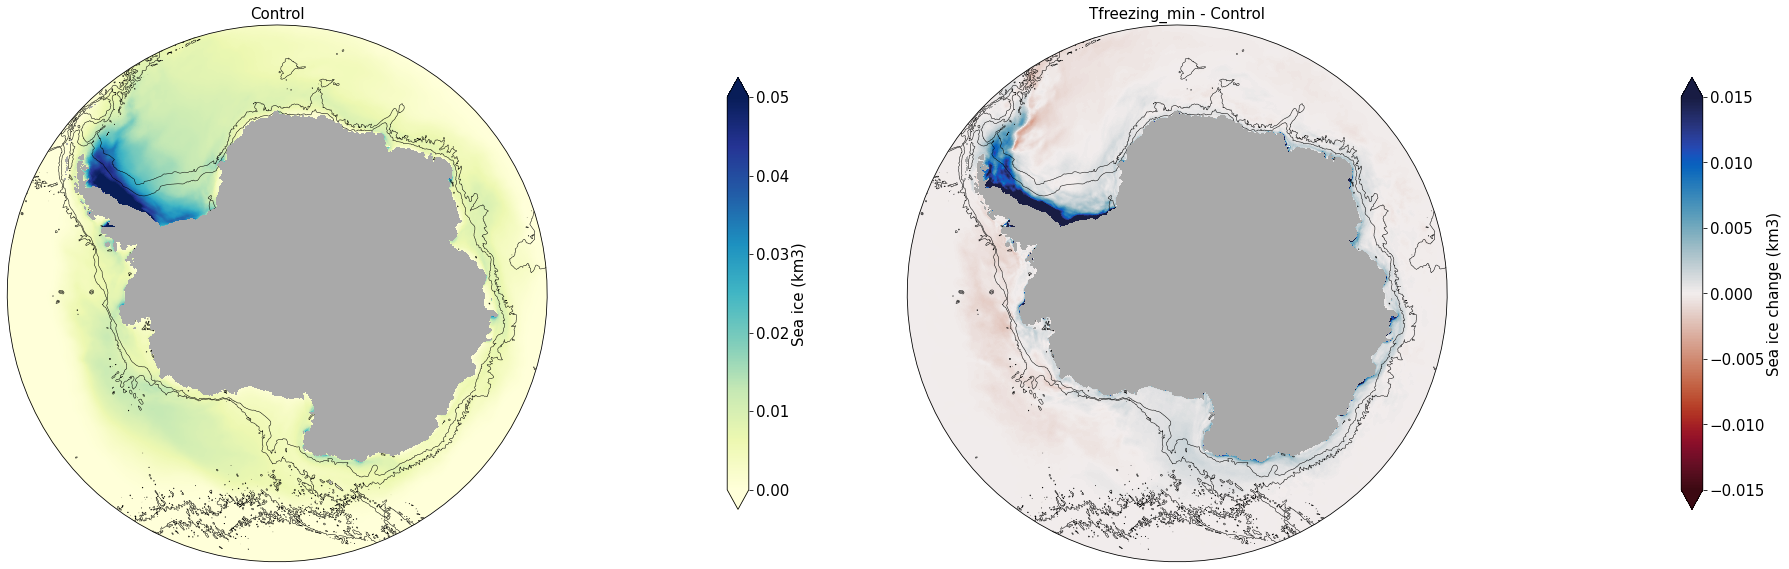

In [32]:
scale_max = .015

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)


# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_con_avet, vmin=0,vmax=0.05,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.4, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min
ax = fig.add_axes([0.5, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_Tfreezing_min_avet-vi_con_avet, norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [5]:
#Time series

In [19]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [20]:
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
vi_con_shelf  = vi_con * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_con_shelf = vi_con_shelf.load()

vi_Tfreezing_min_shelf  = vi_Tfreezing_min * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_Tfreezing_min_shelf = vi_Tfreezing_min_shelf.load()

In [21]:
vi_con_shelf_cpolar  = vi_con_shelf.sum('xt_ocean').sum('yt_ocean')
vi_Tfreezing_min_shelf_cpolar = vi_Tfreezing_min_shelf.sum('xt_ocean').sum('yt_ocean')

In [22]:
# Annual mean 
vi_con_shelf_cpolar_a  = vi_con_shelf_cpolar.groupby('time.year').mean('time')
vi_Tfreezing_min_shelf_cpolar_a = vi_Tfreezing_min_shelf_cpolar.groupby('time.year').mean('time')

In [23]:
# Annual sum 
vi_con_shelf_cpolar_sum  = vi_con_shelf_cpolar.groupby('time.year').sum('time')
vi_Tfreezing_min_shelf_cpolar_sum  = vi_Tfreezing_min_shelf_cpolar.groupby('time.year').sum('time')

In [24]:
#Plotting

In [25]:
# Month labels
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

(0.0, 60.0)

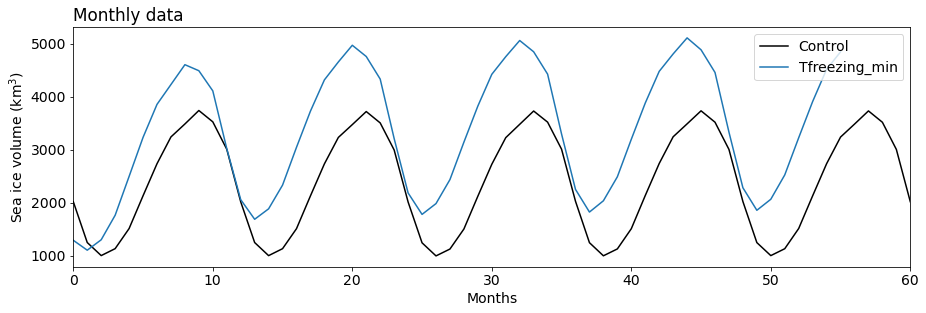

In [26]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly data', loc='left')
plt.plot(vi_con_shelf_cpolar, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,60)

(0.0, 5.0)

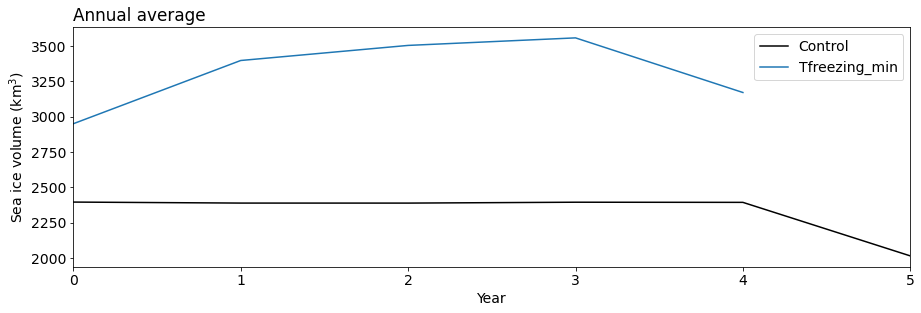

In [27]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual average', loc='left')
plt.plot(vi_con_shelf_cpolar_a, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar_a, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

(0.0, 5.0)

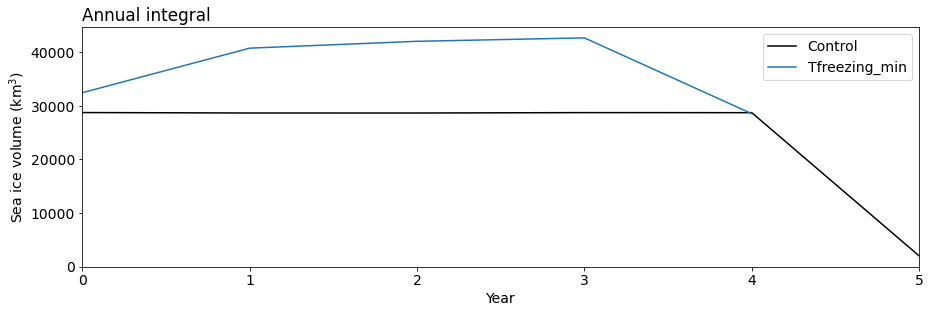

In [28]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual integral', loc='left')
plt.plot(vi_con_shelf_cpolar_sum, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar_sum, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

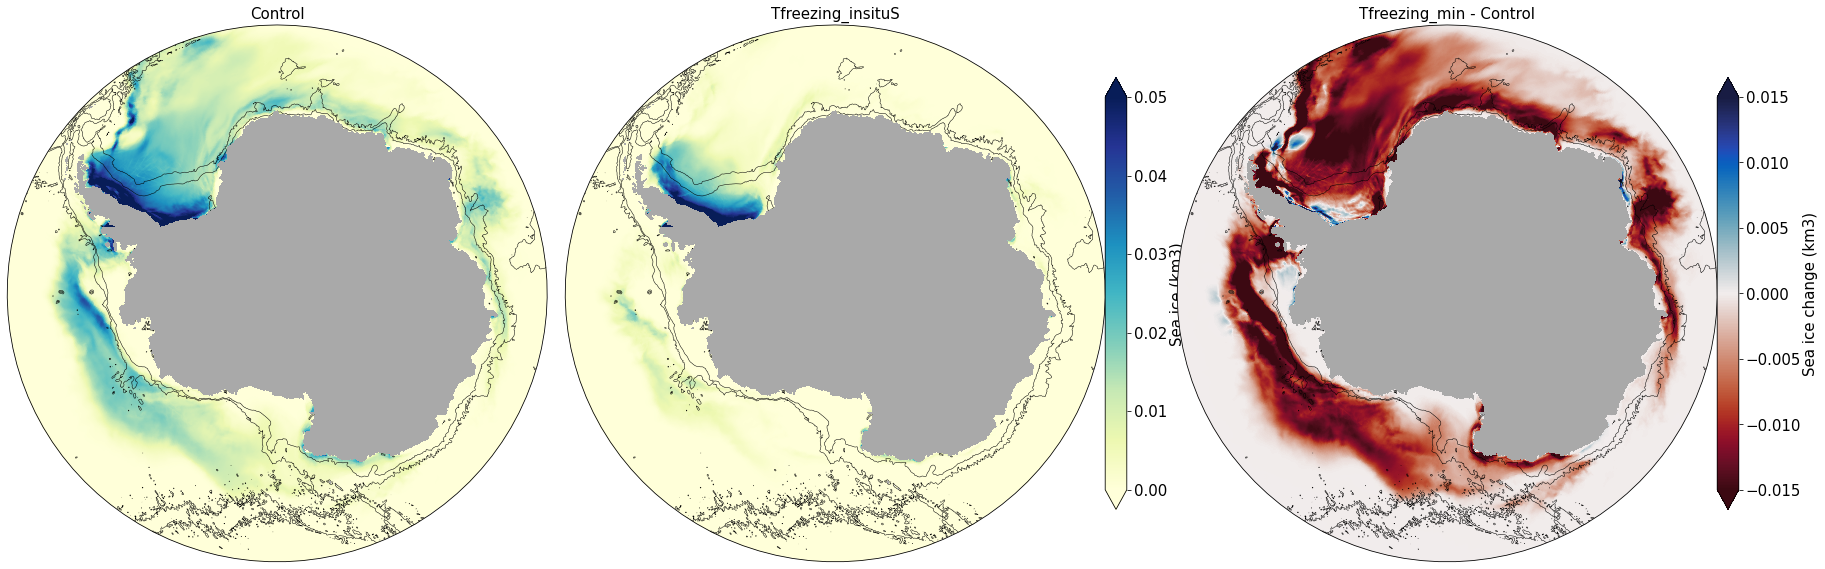

In [33]:
#Sea ice for the first month

scale_max = .015

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)
tt=0

# Control
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_con[tt], vmin=0,vmax=0.05,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_Tfreezing_min[tt], vmin=0,vmax=0.05,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.61, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min
ax = fig.add_axes([0.65, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(vi_con.xt_ocean, vi_con.yt_ocean, vi_Tfreezing_min[tt]-vi_con[tt], norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.95, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)